In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import datasets
delay = pd.read_csv('data/all_years.csv', delimiter='\t')
codes_srt = pd.read_csv('data/codes_srt.csv', delimiter='\t')
codes_sub = pd.read_csv('data/codes_sub.csv', delimiter='\t')
station_names = pd.read_csv('data/station_names.csv')
codes_bins = pd.read_csv('data/codes_bins.csv')

# Merge Datasets
delay = pd.merge(left=delay, right=codes_srt, how='left', left_on=delay['Code'], 
        right_on=codes_srt['SRT RMENU CODE']).drop(columns='key_0',axis=1)

delay = pd.merge(left=delay, right=codes_sub, how='left', 
                left_on=delay['Code'], right_on=codes_sub['SUB RMENU CODE']).drop(columns='key_0', axis=1)

delay = pd.merge(left=delay, right=station_names, how='left',
                left_on=delay['Station'], right_on=station_names['data_station']).drop(columns=['Unnamed: 0','key_0','data_station'],axis=1)

# Create Combo Code Column
delay['combo code'] = delay['CODE DESCRIPTION_y'].fillna(delay['CODE DESCRIPTION_y'])

delay = pd.merge(left=delay, right=codes_bins, how='left', left_on=delay['combo code'], 
                right_on=codes_bins['combo code']).drop(columns=['key_0','combo code_x'], axis=1)
delay = delay.rename(columns={'combo code_y': 'combo code'})

In [3]:
# Filter Dataset
delay = delay.drop(columns=['SRT RMENU CODE','CODE DESCRIPTION_x','SUB RMENU CODE', 
                   'CODE DESCRIPTION_y'])

In [14]:
# What does our data look like
delay.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,real_station,location,real_line,combo code,code bin,Month,Year,Min Delay Hours,Min Gap Hours
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,victoria park,Station,BD,Priority One - Train in Contact With Person,Accident,1,2014,0.916667,1.000000
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,high park,Station,BD,Disorderly Patron,Disorderly Patron,1,2014,0.050000,0.116667
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NA,YU,0,sheppard,Station,NaN,Misc,NaN,1,2014,0.000000,0.000000
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,lansdowne,Station,BD,Disorderly Patron,Disorderly Patron,1,2014,0.050000,0.133333
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,bloor,Station,NaN,Unsanitary Vehicle,Unsantiary Vehicle,1,2014,0.083333,0.166667


### Bound
- Directional in one direction, nulls can be expected as some delays are when subways are not in transit
- Complete Nulls with 'NA'

### real_station
- some "Station" in original datasets are not real subway stations, therefore we can fill Nulls with 'Misc'

### combo code
- some delays are not reported with a reason
- we cant complete this data
- fill in all Nulls with 'misc'

In [4]:
# Complete Missing Values if possible
delay['Bound'] = delay['Bound'].fillna('NA')
delay['real_station'] = delay['real_station'].fillna('Misc')
delay['combo code'] = delay['combo code'].fillna('Misc')

## Data Cleaning

In [5]:
# What are the Data Types are we working with?
delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97677 entries, 0 to 97676
Data columns (total 15 columns):
Date            97677 non-null object
Time            97677 non-null object
Day             97677 non-null object
Station         97677 non-null object
Code            97676 non-null object
Min Delay       97677 non-null int64
Min Gap         97677 non-null int64
Bound           97677 non-null object
Line            97277 non-null object
Vehicle         97677 non-null int64
real_station    97677 non-null object
location        97677 non-null object
real_line       79688 non-null object
combo code      97677 non-null object
code bin        91956 non-null object
dtypes: int64(3), object(12)
memory usage: 11.9+ MB


In [7]:
# Convert data to Datetime
delay['Date'] = pd.to_datetime(delay['Date'])

# Generate Month/Year Variables
delay['Month'] = [i.month for i in delay['Date']]
delay['Year'] = [i.year for i in delay['Date']]

In [8]:
# Get Hours columns for Min Delay/Gap
delay['Min Delay Hours'] = delay['Min Delay']/60
delay['Min Gap Hours'] = delay['Min Gap']/60

## Data Exploration

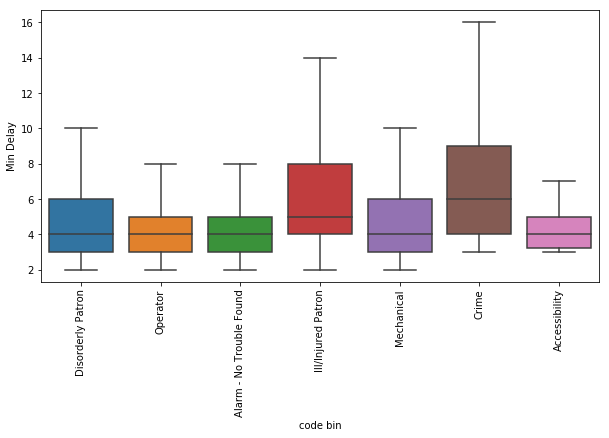

In [6]:
#boxplot
import seaborn as sns
ifg = plt.figure(figsize = (10,5))
df = delay[(delay['code bin'].isin(['Mechanical','Operator','Ill/Injured Patron','Alarm - No Trouble Found', 'Crime', 'Disorderly Patron', 'Accessibility']))
          & (delay['Min Delay'] != 0)]
g= sns.boxplot(data = df, x= 'code bin', y = 'Min Delay',showfliers=False)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

### 1. What are the common types of Min/Delay or Gaps by Station

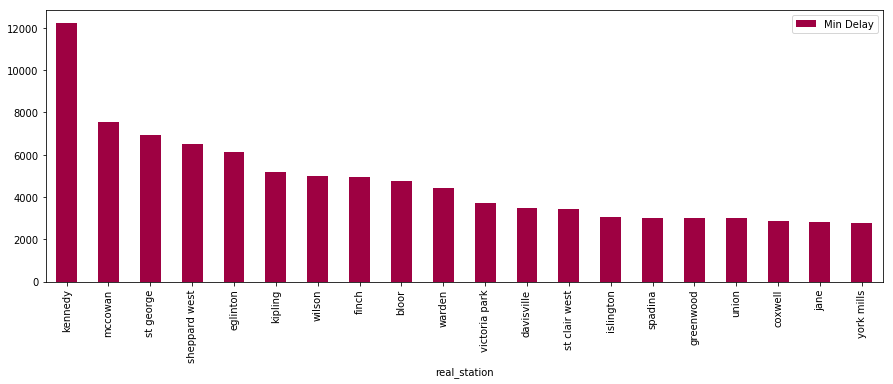

In [7]:
# What are the most delayed stations by total delay time
delay2 = delay.drop(delay[delay.real_station == 'Misc'].index)


delay2[['real_station','Min Delay']].groupby( 
       'real_station').sum().sort_values('Min Delay', ascending=False).head(20).plot(
 
                                              kind='bar',figsize=(15,5),  colormap='Spectral')
plt.show()

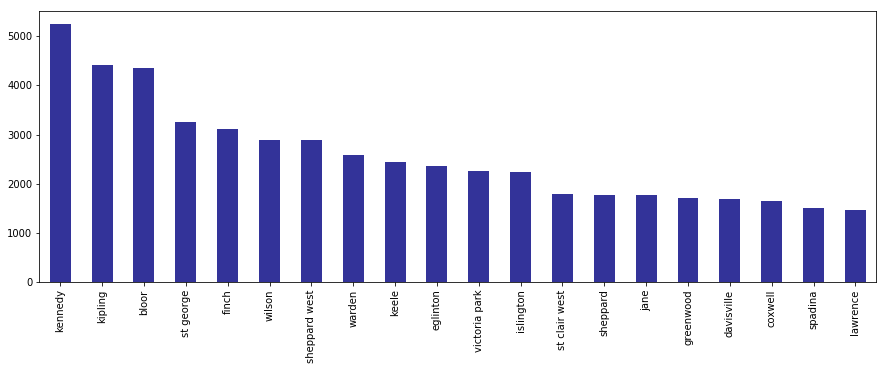

In [8]:

# What are the most delayed stations by frequency of delay

delay2['real_station'].value_counts().sort_values(ascending =False).head(20).plot(kind='bar',figsize=(15,5),
                                     colormap='terrain')
plt.show()


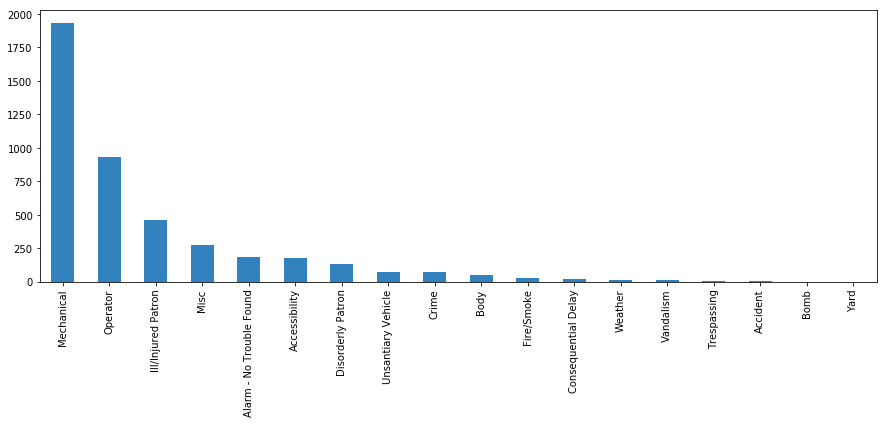

In [11]:

# What are the most commonly delay reason for Kennedy(the station with the most delay time)
import seaborn as sns
delay[delay.real_station == 'kennedy']['code bin'].value_counts().plot(kind='bar',figsize=(15,5),
                                     colormap='tab20c')

plt.show()

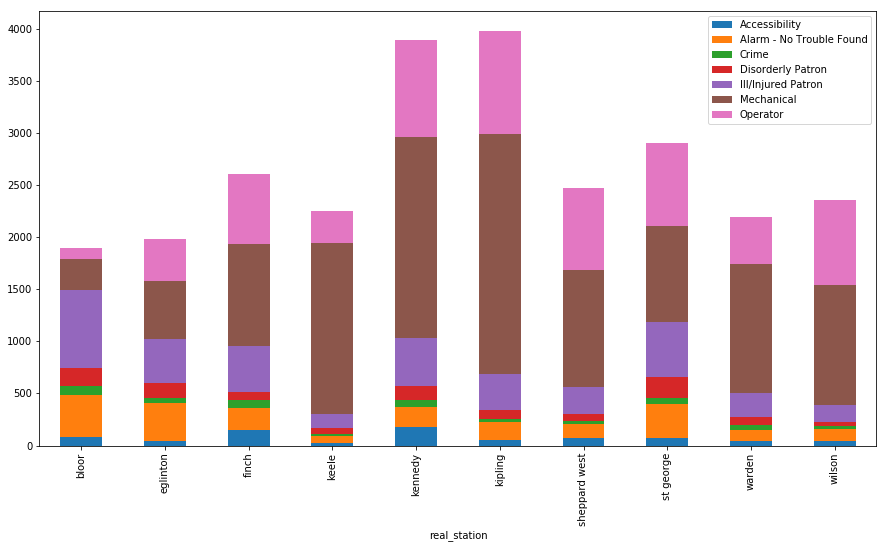

In [9]:
# Distribution of delay reasons for per station
df2 = delay2[(delay2['real_station'].isin(delay2['real_station'].value_counts().sort_values(ascending =False).head(10).index))
            & (delay2['code bin'].isin(['Mechanical','Operator','Ill/Injured Patron','Alarm - No Trouble Found', 'Crime', 'Disorderly Patron', 'Accessibility']))]
temp = pd.crosstab(df2['real_station'], df2['code bin'])


temp.plot(kind  = 'bar', stacked = True, figsize = (15,8))
plt.legend(loc = 'best')

plt.show()
